# Exploring Options for Replacing Covid Tracking Project Data_08-2021

- 07/11/21

## NOTE: FINAL WORKFLOW & FUNCTIONS MOVED TO "`data_acquisition.py` and is used in `2_coronavirus_covid_19_timeseries_forecasting_08-2021.ipynb`

## Goal

- As of 03/07/21 the Covid Tracking Project has stopped collecting new data. 
    - https://covidtracking.com/data
    - This was the primary backbone of my modeling and dashboard and needs to be replaced/ 
    - While I already have an alternative coronavirus source for time series from Kaggle, I want to have the ICU capacity and hospitalization records.
    
    
- Federal Data: 
    - Covid Tracking Project provides info on alternative data sources. https://covidtracking.com/analysis-updates/federal-covid-data-101-how-to-find-data
        - related posts: https://covidtracking.com/analysis-updates/category/federal-covid-data-101
    - They also provide a simple approach for the general public: https://covidtracking.com/analysis-updates/simple-covid-data

- COVID-19 hospitalization data training:
    - Video: https://www.youtube.com/watch?v=TGAHQt1Rkf8
    - Presentaation (my copy): https://docs.google.com/presentation/d/1p5XNS7b9_R40zaBgC5EiWvP1Vs7UJiAXPQ3WP-U9PjI/edit?usp=sharing

# The Code

## Existing Code/Data

In [120]:
# !pip install -U fsds
from fsds.imports import *

import os,zipfile,json,joblib
pd.set_option('display.max_columns',0)

In [121]:
plt.rcParams['figure.figsize'] = [12,6]

In [122]:
## Appending folder with functions
%load_ext autoreload 
%autoreload 2
# import sys
# sys.path.append('.')

import functions as fn
# help(fn)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
# ## original class for using The Covid Tracking Project API
# covid = fn.CovidTrackingProject(verbose=True)
# covid

In [124]:
# covid.df

## Columns to Find

#### Columns to find from the covid tracking project dataset: 

- "hospitalizedCurrently"/"hospitalizedCumulative"
- "inIcuCurrently","inIcuCumulative"
- "onVentilatorCurrently","onVentilatorCumulative"

# New Data Sources

## Kaggle

### Covid-19 Data From Johns Hopkins University

- https://www.kaggle.com/antgoldbloom/covid19-data-from-john-hopkins-university
- Comes with CONVENIENT_ files and RAW_ files.

In [125]:
## Specifying data storage folders
fpath_raw = r"data_raw"
fpath_clean = r"data/"
[os.makedirs(fpath,exist_ok=True) for fpath in [fpath_clean,fpath_raw]];
# sorted(os.listdir())

In [126]:
## Download kaggle jhu data and make zipfile object
!kaggle datasets download -p "{fpath_raw}" -d antgoldbloom/covid19-data-from-john-hopkins-university

jhu_data_zip = zipfile.ZipFile(os.path.join(fpath_raw,'covid19-data-from-john-hopkins-university.zip'))
jhu_data_zip.namelist()

covid19-data-from-john-hopkins-university.zip: Skipping, found more recently modified local copy (use --force to force download)


['CONVENIENT_global_confirmed_cases.csv',
 'CONVENIENT_global_deaths.csv',
 'CONVENIENT_global_metadata.csv',
 'CONVENIENT_us_confirmed_cases.csv',
 'CONVENIENT_us_deaths.csv',
 'CONVENIENT_us_metadata.csv',
 'RAW_global_confirmed_cases.csv',
 'RAW_global_deaths.csv',
 'RAW_us_confirmed_cases.csv',
 'RAW_us_deaths.csv']

In [127]:
# ## Files to extract
# import os 

# files_to_extract = ['RAW_us_confirmed_cases.csv','CONVENIENT_us_confirmed_cases.csv',
#                     'RAW_us_deaths.csv','CONVENIENT_us_deaths.csv','CONVENIENT_us_metadata.csv']
# for i,file in enumerate(files_to_extract):
#     print(f"{i}. {file}")
#     jhu_data_zip.extract(file,path=fpath_raw)

In [128]:
# import os

# ## raw vs conv cases
# raw_us_cases = pd.read_csv(files_to_extract[0],low_memory=False)
# conv_us_cases = pd.read_csv(files_to_extract[1],low_memory=False)
# display(raw_us_cases.head().style.set_caption('raw_us_cases'),
#        conv_us_cases.head().style.set_caption('conv_us_cases'))

# print('---'*30)

# ## raw vs conv deaths 
# raw_us_deaths = pd.read_csv(files_to_extract[2],low_memory=False)
# conv_us_deaths = pd.read_csv(files_to_extract[3],low_memory=False)
# display(raw_us_deaths.head().style.set_caption('raw_us_deaths'),
#        conv_us_deaths.head().style.set_caption('conv_us_deaths'))

- **The RAW_ files** are closer to what I have been working with already so I will stick with those. 

In [129]:
# # metadata
# conv_metadata = pd.read_csv(files_to_extract[4],low_memory=False)
# conv_metadata

### Notes re: kaggle source above

#### Adding State Abbreviations

- Adding 2 letter abbrevtions (more appropriate for column name prefix)


In [130]:
state_abbrevs = pd.read_csv('Reference Data/united_states_abbreviations.csv')
# state_abbrevs.head()

## Making dicts of Name:Abbrev and Abbrev:Name
state_to_abbrevs_map = dict(zip(state_abbrevs['State'],state_abbrevs['Abbreviation']))
abbrev_to_state_map = dict(zip(state_abbrevs['Abbreviation'],state_abbrevs['State']))

state_to_abbrevs_map.keys()

dict_keys(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming', 'Puerto Rico'])

### prep `df_metadata`

In [131]:
# metadata
file = 'CONVENIENT_us_metadata.csv'
jhu_data_zip.extract(file,path=fpath_raw)
df_metadata = pd.read_csv(os.path.join(fpath_raw,file))

## Adding State Abbrevas to kaggle metadata
df_metadata.insert(1,'State_Code',df_metadata['Province_State'].map(state_to_abbrevs_map))
print(df_metadata.isna().sum())

## Dropping us territories
df_metadata.dropna(subset=['State_Code'], inplace=True)

## Saving county info
df_metadata.to_csv(os.path.join(fpath_clean,"us_metadata_counties.csv"),index=False)
df_metadata

Province_State    0
State_Code        6
Admin2            6
Population        0
Lat               0
Long              0
dtype: int64


,Province_State,State_Code,Admin2,Population,Lat,Long
0,Alabama,AL,Autauga,55869,32.539527,-86.644082
1,Alabama,AL,Baldwin,223234,30.727750,-87.722071
2,Alabama,AL,Barbour,24686,31.868263,-85.387129
3,Alabama,AL,Bibb,22394,32.996421,-87.125115
4,Alabama,AL,Blount,57826,33.982109,-86.567906
...,...,...,...,...,...,...
3337,Wyoming,WY,Teton,23464,43.935225,-110.589080
3338,Wyoming,WY,Uinta,20226,41.287818,-110.547578
3339,Wyoming,WY,Unassigned,0,0.000000,0.000000
3340,Wyoming,WY,Washakie,7805,43.904516,-107.680187


In [132]:
## Saving a states-only version with aggregated populations and mean lat/long
df_state_metadata = df_metadata.groupby('Province_State',as_index=False).agg({'Population':'sum',
                                               "Lat":'mean',"Long":"mean"})
df_state_metadata.insert(1,'State_Code',df_state_metadata['Province_State'].map(state_to_abbrevs_map))
df_state_metadata.to_csv(os.path.join(fpath_clean,"us_metadata_states.csv"),index=False)
df_state_metadata

,Province_State,State_Code,Population,Lat,Long
0,Alabama,AL,4903185,31.931113,-84.196785
1,Alaska,AK,740995,56.628273,-139.571540
2,Arizona,AZ,7278717,29.714033,-98.349911
3,Arkansas,AR,3017804,34.005087,-90.033096
4,California,CA,39512223,36.582496,-116.704308
5,Colorado,CO,5758736,37.755612,-102.289687
6,Connecticut,CT,3565287,33.290944,-58.125464
7,Delaware,DE,973764,23.465566,-45.319942
8,District of Columbia,DC,705749,12.968059,-25.672187
9,Florida,FL,21477737,28.101892,-80.303621


In [133]:
## Make new mapper dicts from the final values in metadata
state_to_abbrevs_meta = dict(zip(df_state_metadata['Province_State'],df_state_metadata['State_Code']))
abbrev_to_state_meta = dict(zip(df_state_metadata['State_Code'],df_state_metadata['Province_State']))

## Same mappers as joblib files
joblib.dump(state_to_abbrevs_meta, os.path.join(fpath_clean,'state_names_to_codes_map.joblib'))
joblib.dump(abbrev_to_state_meta, os.path.join(fpath_clean,'state_codes_to_names_map.joblib'))

## save mapper fo state to code for function
mapper_path = os.path.join(fpath_clean,'state_names_to_codes_map.joblib')
mapper_path

'data/state_names_to_codes_map.joblib'

### Def Functions

In [134]:
def load_raw_ts_file(jhu_data_zip, file = 'RAW_us_confirmed_cases.csv',
                     mapper_path='data/state_names_to_codes_map.joblib',
                    verbose=True):
    
    if verbose: 
        print(f"Loading data from {file}")
    state_to_abbrevs_meta = joblib.load(mapper_path)
    
    ## Extract and load csv
    jhu_data_zip.extract(file)
    data = pd.read_csv(file)
    
    ## Drop states not included in metadata
    data.insert(1,'State_Code',data['Province_State'].map(state_to_abbrevs_meta))
    data.dropna(subset=['State_Code'],inplace=True)
    return data



def melt_df_to_ts(df_cases,value_name, var_name='Date',
                  multi_index_cols=['State_Code','Date'],
                  id_cols = ['Province_State',"State_Code",'Admin2'],
                  cols_to_drop=['iso2','iso3','code3','UID','Country_Region',
                                'Combined_Key','Lat','Long_','FIPS']):
    
#     value_cols = [c for c in df_cases.columns if c not in [*cols_to_drop,*id_cols]]
    
    ## Remove any cols not in the actual dataframe
    id_cols = [c for c in id_cols if c in df_cases.columns] 
    cols_to_drop = [c for c in cols_to_drop if c in df_cases.columns] 
    
    ## CHECKING FOR NON-DATE COLS TO REMOVE
    value_cols = [c for c in df_cases.columns if c not in [*id_cols,*cols_to_drop]]
    value_cols = list(filter(lambda x: len(x.split('/'))>1,value_cols))
    
    
    df_cases_ts = pd.melt(df_cases, 
                          id_vars=id_cols, value_vars=value_cols,
                          var_name=var_name, value_name=value_name)
    
    df_cases_ts['Date'] = pd.to_datetime(df_cases_ts['Date'])
    df_cases_ts = df_cases_ts.set_index(multi_index_cols).sort_index()
    return df_cases_ts

### Prep ` df_cases_ts`

In [135]:
## Prep ` df_cases_ts`
df_cases = load_raw_ts_file(jhu_data_zip, file = 'RAW_us_confirmed_cases.csv',)
df_cases_ts = melt_df_to_ts(df_cases,'Cases')
df_cases_ts

Loading data from RAW_us_confirmed_cases.csv


Province_State          Admin2  Cases
State_Code Date                                            
AK         2020-01-22         Alaska  Aleutians East      0
           2020-01-22         Alaska  Aleutians West      0
           2020-01-22         Alaska       Anchorage      0
           2020-01-22         Alaska          Bethel      0
           2020-01-22         Alaska     Bristol Bay      0
...                              ...             ...    ...
WY         2021-08-14        Wyoming           Teton   4068
           2021-08-14        Wyoming           Uinta   2593
           2021-08-14        Wyoming      Unassigned      0
           2021-08-14        Wyoming        Washakie    967
           2021-08-14        Wyoming          Weston    705

[1904856 rows x 3 columns]

### Prep ` df_deaths_ts`

In [136]:
## Prep df_deaths_ts
df_deaths = load_raw_ts_file(jhu_data_zip,file = 'RAW_us_deaths.csv')
df_deaths_ts = melt_df_to_ts(df_deaths,'Deaths')
df_deaths_ts

Loading data from RAW_us_deaths.csv


Province_State          Admin2  Deaths
State_Code Date                                             
AK         2020-01-22         Alaska  Aleutians East       0
           2020-01-22         Alaska  Aleutians West       0
           2020-01-22         Alaska       Anchorage       0
           2020-01-22         Alaska          Bethel       0
           2020-01-22         Alaska     Bristol Bay       0
...                              ...             ...     ...
WY         2021-08-14        Wyoming           Teton      11
           2021-08-14        Wyoming           Uinta      14
           2021-08-14        Wyoming      Unassigned       0
           2021-08-14        Wyoming        Washakie      26
           2021-08-14        Wyoming          Weston       6

[1904856 rows x 3 columns]

### Test Concat

In [137]:
# pd.concat([df_cases_ts.loc['Alabama','Confirmed Cases'],df_deaths_ts.loc['Alabama','Deaths']])

In [119]:
# pd.merge(df_cases_ts,df_deaths_ts)

In [140]:
## Merge df_cases_ts and df_deaths_ts
df_cases_deaths_ts = pd.merge(df_cases_ts.reset_index(), df_deaths_ts.reset_index())
df_cases_deaths_ts

,State_Code,Date,Province_State,Admin2,Cases,Deaths
0,AK,2020-01-22,Alaska,Aleutians East,0,0
1,AK,2020-01-22,Alaska,Aleutians West,0,0
2,AK,2020-01-22,Alaska,Anchorage,0,0
3,AK,2020-01-22,Alaska,Bethel,0,0
4,AK,2020-01-22,Alaska,Bristol Bay,0,0
...,...,...,...,...,...,...
1904851,WY,2021-08-14,Wyoming,Teton,4068,11
1904852,WY,2021-08-14,Wyoming,Uinta,2593,14
1904853,WY,2021-08-14,Wyoming,Unassigned,0,0
1904854,WY,2021-08-14,Wyoming,Washakie,967,26


#### Saving df_cases_deaths_ts `'us_states_cases_deaths.csv'`

In [144]:
df_cases_deaths.to_csv(os.path.join(fpath_clean,'us_states_cases_deaths.csv'),index=True)

### Making & saving  "`df_daily_cases_deaths_ts`"

In [170]:
df_daily_cases_deaths_ts = df_cases_deaths_ts.set_index('Date')\
                                .groupby('State_Code').resample("D")\
                                    .sum().reset_index()
df_daily_cases_deaths_ts.to_csv(os.path.join(fpath_clean,'us_states_daily_cases_deaths.csv'),index=True)
df_daily_cases_deaths_ts

,State_Code,Date,Cases,Deaths
0,AK,2020-01-22,0,0
1,AK,2020-01-23,0,0
2,AK,2020-01-24,0,0
3,AK,2020-01-25,0,0
4,AK,2020-01-26,0,0
...,...,...,...,...
29687,WY,2021-08-10,67326,793
29688,WY,2021-08-11,67582,793
29689,WY,2021-08-12,67957,793
29690,WY,2021-08-13,68272,793


In [145]:
# from itertools import chain
# # df_cases_deaths = pd.concat(list(chain(STATES.values())),axis=1)
# # df_cases_deaths

In [146]:
# pd.concat([df_cases_ts,df_deaths_ts],axis=1)

### Test Join- Maryland Deaths and Cases Data

In [31]:
# ## Testing md data -  reset index for multi-column join
# md_cases = df_cases_ts.loc['Maryland'].reset_index()
# md_cases

In [32]:
# ## Testing md data -  reset index for multi-column join
# md_deaths = df_deaths_ts.loc['Maryland'].reset_index()
# md_deaths

In [33]:
# df_md = pd.merge(md_cases, md_deaths, on=['Date','Admin2'])
# df_md = df_md.set_index("Date").resample('D').sum()

# df_md.plot(subplots=True)

In [34]:
# df_md_diff = df_md.diff().fillna(0)#.plot(subplots=True)
# df_md_diff.plot(subplots=True)

- 

___

# UP TO HERE ADDED TO - SIMPLIFIED WORKFLOW NOTEBOOK

## Previous Hospital Data

In [39]:
## original class for using The Covid Tracking Project API
covid = fn.CovidTrackingProject(verbose=True)
covid

[i] DOWNLOADING DATASETS FROM COVID TRACKING PROJECT
	https://covidtracking.com/data
	- File saved as: "New Data/states_metadata.csv"
ERROR
	- File saved as: "New Data/us.csv"
	- File saved as: "New Data/states.csv"
states


------------------------------------------------------------
[i] CovidTrackingProject Contents:
------------------------------------------------------------

METHODS:
	download_state_daily
	download_state_meta
	download_us_daily
	get_csv_save_load
	get_df
	get_group_ts
	help

ATTRIBUTES
	base_folder
	base_url
	columns
	columns_us
	df
	df_states
	df_us
	urls

In [40]:
# md = covid.get_group_ts('MD')
# md
df_prev = covid.df_us.copy()
df_prev

,positive,negative,death,recovered,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,states,pending,dateChecked,hash
date,,,,,,,,,,,,,,
2021-03-07,28756489.0,74582825.0,515151.0,NaN,40199.0,776361.0,8134.0,45475.0,2802.0,4281.0,56,11808.0,2021-03-07T24:00:00Z,a80d0063822e251249fd9a44730c49cb23defd83
2021-03-06,28714654.0,74450990.0,514309.0,NaN,41401.0,775635.0,8409.0,45453.0,2811.0,4280.0,56,11783.0,2021-03-06T24:00:00Z,dae5e558c24adb86686bbd58c08cce5f610b8bb0
2021-03-05,28654639.0,74307155.0,512629.0,NaN,42541.0,775132.0,8634.0,45373.0,2889.0,4275.0,56,12213.0,2021-03-05T24:00:00Z,724844c01659d0103801c57c0f72bf8cc8ab025c
2021-03-04,28585852.0,74035238.0,510408.0,NaN,44172.0,772351.0,8970.0,45293.0,2973.0,4267.0,56,12405.0,2021-03-04T24:00:00Z,5c549ad30f9abf48dc5de36d20fa707014be1ff3
2021-03-03,28520365.0,73857281.0,508665.0,NaN,45462.0,770821.0,9359.0,45214.0,3094.0,4260.0,56,11778.0,2021-03-03T24:00:00Z,fef6c425d2b773a9221fe353f13852f3e4a4bfb0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-17,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,2020-01-17T24:00:00Z,5fd7ed7fb0f83565ea0aaaf5ff6104e5860be2d6
2020-01-16,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,2020-01-16T24:00:00Z,4c0f2ea879eefec1a18a93bcd8a382ea56cd452d
2020-01-15,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,2020-01-15T24:00:00Z,8a449023413eea473277416e9e30ae126c6af047


### Columns to find from the covid tracking project dataset: 

- Old: "hospitalizedCurrently"/"hospitalizedCumulative"
    - New: "inpatient_beds_utilization"
- "inIcuCurrently","inIcuCumulative"
    - New: "adult_icu_bed_utilization
- "onVentilatorCurrently","onVentilatorCumulative"

In [41]:
df_prev['hospitalizedCurrently']

date
2021-03-07    40199.0
2021-03-06    41401.0
2021-03-05    42541.0
2021-03-04    44172.0
2021-03-03    45462.0
               ...   
2020-01-17        NaN
2020-01-16        NaN
2020-01-15        NaN
2020-01-14        NaN
2020-01-13        NaN
Name: hospitalizedCurrently, Length: 420, dtype: float64

<AxesSubplot:xlabel='date'>

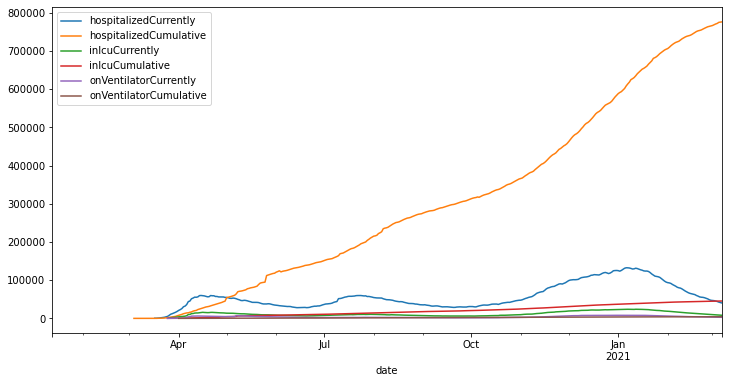

In [43]:
## Visualize columnns to reporduce
cols_to_find = ['hospitalizedCurrently','hospitalizedCumulative',
               'inIcuCurrently','inIcuCumulative','onVentilatorCurrently',
               'onVentilatorCumulative']
df_prev[cols_to_find].plot()

## New Data.Gov Hospital Data

### `"COVID-19 Reported Patient Impact and Hospital Capacity by State Timeseries API"`
- https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh

- API URL (csv): https://healthdata.gov/resource/g62h-syeh.csv
- ~~geojson url: https://healthdata.gov/resource/g62h-syeh.geojson~~

In [44]:
# df1_downloaded = pd.read_csv('/Users/jamesirving/Downloads/COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_State_Timeseries.csv')
# df1_downloaded

In [150]:
# base_url = 'https://healthdata.gov/resource/g62h-syeh.csv'
# df1 = pd.read_csv(base_url)
# df1['date'] = pd.to_datetime(df1['date'])
# df1.sort_values(['date'])#

### Why do I get more data if I download? Pagination?
- https://dev.socrata.com/docs/paging.html

In [46]:
# url =base_url+"?$offset=1000"
# pd.read_csv(url)

In [47]:
## Getting Hospital Capacity Data
# base_url = 'https://healthdata.gov/resource/g62h-syeh.csv'
# df1 = pd.read_csv(base_url)
# df1['date'] = pd.to_datetime(df1['date'])
# df1 = df1.sort_values(['state','date'])
# df1

### Def Function to Get Pages of Data from HHS

In [50]:
def get_hospital_data():
    offset = 0
    ## Getting Hospital Capacity Data
    base_url = 'https://healthdata.gov/resource/g62h-syeh.csv'
    page = 0
    results = []

    ## seting random, large page-len
    page_len = 1000

    while (page_len>0):
        try:
            print(f"[i] Page {page} (offset = {offset})")
            url = base_url+f"?$offset={offset}"
            df_temp = pd.read_csv(url)
            results.append(df_temp)

            page_len = len(df_temp)
            offset+=page_len
            page+=1
        except Exception as e:
            print('[!] ERROR:')
            print(e)
            print('-- returning raw results list instead of dataframe..')
            return results
        
    return pd.concat(results)

# hospital_df = get_hospital_data()
# hospital_df

In [51]:
## Get hospital data with function
df1 = get_hospital_data()
df1['date'] = pd.to_datetime(df1['date'])
df1 = df1.sort_values(['state','date'])
df1

[i] Page 0 (offset = 0)
[i] Page 1 (offset = 1000)
[i] Page 2 (offset = 2000)
[i] Page 3 (offset = 3000)
[i] Page 4 (offset = 4000)
[i] Page 5 (offset = 5000)
[i] Page 6 (offset = 6000)
[i] Page 7 (offset = 7000)
[i] Page 8 (offset = 8000)
[i] Page 9 (offset = 9000)
[i] Page 10 (offset = 10000)
[i] Page 11 (offset = 11000)
[i] Page 12 (offset = 12000)
[i] Page 13 (offset = 13000)
[i] Page 14 (offset = 14000)
[i] Page 15 (offset = 15000)
[i] Page 16 (offset = 16000)
[i] Page 17 (offset = 17000)
[i] Page 18 (offset = 18000)
[i] Page 19 (offset = 19000)
[i] Page 20 (offset = 20000)
[i] Page 21 (offset = 21000)
[i] Page 22 (offset = 22000)
[i] Page 23 (offset = 23000)
[i] Page 24 (offset = 24000)
[i] Page 25 (offset = 25000)
[i] Page 26 (offset = 26000)
[i] Page 27 (offset = 27000)
[i] Page 28 (offset = 28000)
[i] Page 29 (offset = 28477)


,state,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,inpatient_beds,inpatient_beds_coverage,inpatient_beds_used,inpatient_beds_used_coverage,inpatient_beds_used_covid,inpatient_beds_used_covid_coverage,previous_day_admission_adult_covid_confirmed,previous_day_admission_adult_covid_confirmed_coverage,previous_day_admission_adult_covid_suspected,previous_day_admission_adult_covid_suspected_coverage,previous_day_admission_pediatric_covid_confirmed,previous_day_admission_pediatric_covid_confirmed_coverage,previous_day_admission_pediatric_covid_suspected,previous_day_admission_pediatric_covid_suspected_coverage,staffed_adult_icu_bed_occupancy,staffed_adult_icu_bed_occupancy_coverage,staffed_icu_adult_patients_confirmed_and_suspected_covid,staffed_icu_adult_patients_confirmed_and_suspected_covid_coverage,staffed_icu_adult_patients_confirmed_covid,staffed_icu_adult_patients_confirmed_covid_coverage,total_adult_patients_hospitalized_confirmed_and_suspected_covid,total_adult_patients_hospitalized_confirmed_and_suspected_covid_coverage,total_adult_patients_hospitalized_confirmed_covid,total_adult_patients_hospitalized_confirmed_covid_coverage,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_coverage,total_pediatric_patients_hospitalized_confirmed_covid,total_pediatric_patients_hospitalized_confirmed_covid_coverage,total_staffed_adult_icu_beds,total_staffed_adult_icu_beds_coverage,...,adult_icu_bed_utilization_denominator,geocoded_state,previous_day_admission_adult_covid_confirmed_18_19,previous_day_admission_adult_covid_confirmed_18_19_coverage,previous_day_admission_adult_covid_confirmed_20_29,previous_day_admission_adult_covid_confirmed_20_29_coverage,previous_day_admission_adult_covid_confirmed_30_39,previous_day_admission_adult_covid_confirmed_30_39_coverage,previous_day_admission_adult_covid_confirmed_40_49,previous_day_admission_adult_covid_confirmed_40_49_coverage,previous_day_admission_adult_covid_confirmed_50_59,previous_day_admission_adult_covid_confirmed_50_59_coverage,previous_day_admission_adult_covid_confirmed_60_69,previous_day_admission_adult_covid_confirmed_60_69_coverage,previous_day_admission_adult_covid_confirmed_70_79,previous_day_admission_adult_covid_confirmed_70_79_coverage,previous_day_admission_adult_covid_confirmed_80,previous_day_admission_adult_covid_confirmed_80_coverage,previous_day_admission_adult_covid_confirmed_unknown,previous_day_admission_adult_covid_confirmed_unknown_coverage,previous_day_admission_adult_covid_suspected_18_19,previous_day_admission_adult_covid_suspected_18_19_coverage,previous_day_admission_adult_covid_suspected_20_29,previous_day_admission_adult_covid_suspected_20_29_coverage,previous_day_admission_adult_covid_suspected_30_39,previous_day_admission_adult_covid_suspected_30_39_coverage,previous_day_admission_adult_covid_suspected_40_49,previous_day_admission_adult_covid_suspected_40_49_coverage,previous_day_admission_adult_covid_suspected_50_59,previous_day_admission_adult_covid_suspected_50_59_coverage,previous_day_admission_adult_covid_suspected_60_69,previous_day_admission_adult_covid_suspected_60_69_coverage,previous_day_admission_adult_covid_suspected_70_79,previous_day_admission_adult_covid_suspected_70_79_coverage,previous_day_admission_adult_covid_suspected_80_,previous_day_admission_adult_covid_suspected_80_coverage,previous_day_admission_adult_covid_suspected_unknown,previous_day_admission_adult_covid_suspected_unknown_coverage,deaths_covid,deaths_covid_coverage
479,AK,2020-03-23,0,0,1,0,0,1,0.0,1,56.0,1,21.0,1,3.0,1,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,...

In [52]:
# unique_states_hospitals = df1['state'].unique()
# unique_states_hospitals

In [53]:
# [c for c in df1.columns if 'vent' in c]

In [54]:
# df1 = df1.set_index(['state','date'])
# df1

- Need to reconcile what dates are and are not included

In [55]:
# df1

#### [Column Notes](https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh)
- General Naming Schemes:
    - "...coverage" columns:
        - coverage columns seem to all represent # of hospitals reporting for that stat. 
    - "...utilization" columns:
        - seem to be the metrics I am looking for
            - have "utilization",+'_denominator'+'numerator" columns for each
    
    
    
- Groups of columns:
    - "critical_staffing_shortage" columns:
        - "critical_staffing_shortage_today"...
            - yes, no, not_reported
        - "critical_staffing_anticipated_within_week"....
            - yes,no,not_reported
    - "hospital_onset"...
    - "inpatient_beds"...
    - "previous_day_admission"..
        

In [57]:
# ## Save columns removed from main dataframe
# df_hospital_meta = df1[['state','date',*coverage_cols]].copy()
# df_hospital_meta.head()

### Column Sorting Approach

- Remove less in THIS notebook, save for modeling notebook.
- Filter out big-categories of unwanted column names before finding specific-category column names
    - staffing
    - previous_data
    - coverage

In [63]:
## testing dictionary
from copy import deepcopy
COLUMNS = {}

# ## SAVING unwanted columns to COLUMNS dict
drop_col_expressions = ['staffing','previous_day','coverage']
for expr in drop_col_expressions:
    COLUMNS[expr] = [c for c in df1.columns if expr in c]
    
COLUMNS.keys()

dict_keys(['staffing', 'previous_day', 'coverage'])

In [66]:
# from: https://www.geeksforgeeks.org/python-concatenate-dictionary-value-lists/
from itertools import chain
DROP_COLS = set(list(chain(*COLUMNS.values())))
DROP_COLS

{'adult_icu_bed_covid_utilization_coverage',
 'adult_icu_bed_utilization_coverage',
 'critical_staffing_shortage_anticipated_within_week_no',
 'critical_staffing_shortage_anticipated_within_week_not_reported',
 'critical_staffing_shortage_anticipated_within_week_yes',
 'critical_staffing_shortage_today_no',
 'critical_staffing_shortage_today_not_reported',
 'critical_staffing_shortage_today_yes',
 'deaths_covid_coverage',
 'hospital_onset_covid_coverage',
 'inpatient_bed_covid_utilization_coverage',
 'inpatient_beds_coverage',
 'inpatient_beds_used_coverage',
 'inpatient_beds_used_covid_coverage',
 'inpatient_beds_utilization_coverage',
 'percent_of_inpatients_with_covid_coverage',
 'previous_day_admission_adult_covid_confirmed',
 'previous_day_admission_adult_covid_confirmed_18_19',
 'previous_day_admission_adult_covid_confirmed_18_19_coverage',
 'previous_day_admission_adult_covid_confirmed_20_29',
 'previous_day_admission_adult_covid_confirmed_20_29_coverage',
 'previous_day_admissi

In [62]:
### REPLACED ABOVE
# ## collecting lists of colun names (see md cell above with notes )

# ## unneeded cols
# staffing_cols = [c for c in df1.columns if "staffing" in c]
# previous_day_cols = [c for c in df1.columns if "previous_day" in c]
# coverage_cols = [c for c in df1.columns if "coverage" in c]

# COLUMNS['staffing'] = deepcopy(staffing_cols)
# COLUMNS['coverage'] = deepcopy(coverage_cols)
# COLUMNS['previous_day'] = 

# DROP_COLS = list(set([*staffing_cols,*previous_day_cols,*coverage_cols]))
# len(DROP_COLS)

## 🎗**BOOKMARK 08/13 - SIMPLIFYING HHS DATA WORKFLOW**

### OOP Way: `ColumnDict`

In [67]:
# class ColumnDict(dict):
#     pass
    
#     def get_all_values(self):

#         from itertools import chain
#         return [*self.id_cols,*set(list(chain(*self.values())))]

In [68]:
# help(dict)

### `ColumnDict` To-Dos:
- [ ] p1: Add way of resolving columns that are in both keep cols and drop cols
- [ ] p2: have find_expr_cols also accept a list of tuples with the `[(col_name,keep=True/False)]`


In [69]:
class ColumnDict(dict):
    """Inherits from a normal dictionary.
    
    Methods:
        find_expr_cols: methods for finding columns based on expressions
                        saves the column names under with the expression  as key
        get_all_values: gets list of all unique values stored in dict
    Adds 
    Also saved keep_keys True/False dict of expressions that should be kept or dropped
    """
    keep_keys = {True:list(),False:list(),'id':list()} # Expressions 
    keep_cols = {True:list(),False:list()} # column names
    
    def __init__(self, id_cols=[],*args,**kwargs):

        self.id_cols=id_cols
        ## Empty list of keep keys/cols
#         self['id'] = self.id_cols
        self.keep_keys = {True:list(),False:list(),'id':self.id_cols} # Expressions 
        self.keep_cols = {True:[*self.id_cols],False:list()} # column names
    #     id_cols = list() ## id columns to be auto-kept 
        super().__init__(*args,**kwargs)
    
    
    def get_all_values(self,keep=None):
        """Retrieves list of unique column names:
        Args:
            keep (None, True, False): determines subset of columns returned
            # Adapter from: https://www.geeksforgeeks.org/python-concatenate-dictionary-value-lists/
            """
        if keep is None:
            from itertools import chain
            return [*self.id_cols,*set(list(chain(*self.values())))]
        
        elif keep==True:
            col_list = list(set(self.keep_cols[keep]))
            return [*self.id_cols, *[c for c in col_list if c not in self.id_cols]]
#             return list(set([*self.id_cols,*]))
        elif keep==False:
            return list(set(self.keep_cols[keep]))

        
        
    def find_expr_cols(self,expressions,df,keep,exlcude_known_cols=None):
        """Saves lists of column names as values in dict
        Args:
            Expresssions (str,list): patterns to find in column names 
            df (DataFrame): dataframe to check
            keep (bool): saves expr and cols keep_cols/keep_keys as True or False
            
        TO DO:
            exlcude_known_cols (NOT IMPLEMENTED YET): will check if found columns 
                                are already in any of the known lists of cols
                                
                                
                                
        EXAMPLE USAAGE:
        >>> COLUMNS = ColumnDict()
        >>> COLUMNS.find_expr_cols(['staffing','previous_day','coverage'],
                                    df1,keep=False)
        """
            
        if isinstance(expressions,str):
                expressions = [expressions]
                
        for expr in expressions:
            found_cols = [c for c in df.columns if expr in c]
            self[expr] = found_cols

            ## Save exression and fond_cols to keep_keys/keep_cols
            self.keep_keys[keep].append(expr)
            
            [self.keep_cols[keep].append(c) for c in found_cols if c not in self.keep_cols[keep]]





In [70]:
## Using Column Dict 

COLUMNS = ColumnDict(id_cols=['state','date'])

## saving names to DROP to COLUMNS dict
drop_col_expressions = ['staff','previous_day','coverage','onset']
COLUMNS.find_expr_cols(drop_col_expressions,df1,keep=False)


## saving names to KEEP to COLUMNS dict

keep_col_expressions = ['inpatient_bed','adult_icu_bed','utilization',
                        'total_adult_patients','total_pediatric_patients',
                       'percent_of_inpatients_with_covid','deaths']
COLUMNS.find_expr_cols(keep_col_expressions,df1,keep=True)

COLUMNS.keep_cols[True]

['state',
 'date',
 'inpatient_beds',
 'inpatient_beds_coverage',
 'inpatient_beds_used',
 'inpatient_beds_used_coverage',
 'inpatient_beds_used_covid',
 'inpatient_beds_used_covid_coverage',
 'inpatient_beds_utilization',
 'inpatient_beds_utilization_coverage',
 'inpatient_beds_utilization_numerator',
 'inpatient_beds_utilization_denominator',
 'inpatient_bed_covid_utilization',
 'inpatient_bed_covid_utilization_coverage',
 'inpatient_bed_covid_utilization_numerator',
 'inpatient_bed_covid_utilization_denominator',
 'staffed_adult_icu_bed_occupancy',
 'staffed_adult_icu_bed_occupancy_coverage',
 'total_staffed_adult_icu_beds',
 'total_staffed_adult_icu_beds_coverage',
 'adult_icu_bed_covid_utilization',
 'adult_icu_bed_covid_utilization_coverage',
 'adult_icu_bed_covid_utilization_numerator',
 'adult_icu_bed_covid_utilization_denominator',
 'adult_icu_bed_utilization',
 'adult_icu_bed_utilization_coverage',
 'adult_icu_bed_utilization_numerator',
 'adult_icu_bed_utilization_denominato

In [71]:
## id cols saves as attribute
COLUMNS.id_cols

['state', 'date']

In [72]:
COLUMNS.keep_keys

{True: ['inpatient_bed',
  'adult_icu_bed',
  'utilization',
  'total_adult_patients',
  'total_pediatric_patients',
  'percent_of_inpatients_with_covid',
  'deaths'],
 False: ['staff', 'previous_day', 'coverage', 'onset'],
 'id': ['state', 'date']}

In [73]:
COLUMNS.keep_cols

{True: ['state',
  'date',
  'inpatient_beds',
  'inpatient_beds_coverage',
  'inpatient_beds_used',
  'inpatient_beds_used_coverage',
  'inpatient_beds_used_covid',
  'inpatient_beds_used_covid_coverage',
  'inpatient_beds_utilization',
  'inpatient_beds_utilization_coverage',
  'inpatient_beds_utilization_numerator',
  'inpatient_beds_utilization_denominator',
  'inpatient_bed_covid_utilization',
  'inpatient_bed_covid_utilization_coverage',
  'inpatient_bed_covid_utilization_numerator',
  'inpatient_bed_covid_utilization_denominator',
  'staffed_adult_icu_bed_occupancy',
  'staffed_adult_icu_bed_occupancy_coverage',
  'total_staffed_adult_icu_beds',
  'total_staffed_adult_icu_beds_coverage',
  'adult_icu_bed_covid_utilization',
  'adult_icu_bed_covid_utilization_coverage',
  'adult_icu_bed_covid_utilization_numerator',
  'adult_icu_bed_covid_utilization_denominator',
  'adult_icu_bed_utilization',
  'adult_icu_bed_utilization_coverage',
  'adult_icu_bed_utilization_numerator',
  'ad

In [74]:
len(COLUMNS.get_all_values(keep=None))

98

In [75]:
len(COLUMNS.get_all_values(keep=True))

42

In [76]:
len(COLUMNS.get_all_values(keep=False))

73

In [77]:
# DROP_COLS

In [78]:
# ## SAFE TEMP DF FOR FILTERING 
# df_temp = df1.drop(columns=COLUMNS.get_all_values(keep=False)).copy()
# df_temp

In [79]:
# [c for c in df_temp.columns if 'inpatient_beds' in c]

In [80]:
# KEEP_COLS = COLUMNS.get_all_values(True)
# KEEP_COLS

In [81]:
# ## needed cols (utilization )
# # raw_inpatient_beds =  ['inpatient_beds','inpatient_beds_used','inpatient_beds_used_covid']

# inpatient_bed_util_cols = [c for c in df_temp.columns if 'inpatient_beds_utilization' in c]
# adult_icu_util_cols = [c for c in df_temp.columns if 'adult_icu_bed_utilization'in c]


# ## COMBINING ABOVE LISTS INTO DROP AND KEEP LISTS
# KEEP_COLS = list(set(['date','state',*inpatient_bed_util_cols,*adult_icu_util_cols,
#             *raw_inpatient_beds]))
# len(KEEP_COLS)

In [82]:
# missed_cols = [ c for c in df1.columns if c not in [*DROP_COLS,*UNSURE_COLS,*KEEP_COLS]]
# missed_cols

### Making `df_hospitals`

In [153]:
FULL_WORKFLOW =True

import datetime as dt
today = dt.date.today().strftime("%m-%d-%Y")
# df1.to_csv(os.path.join(fpath_raw,f'hospital_data_{today}.csv'))


if FULL_WORKFLOW:
    ## Get hospital data with function

    ## Get hospital data with function
    df1 = get_hospital_data()
    df1 = df1.rename({'state':'State_Code',
                     'date':'Date'},axis=1)
    df1['Date'] = pd.to_datetime(df1['Date'])
    df1 = df1.sort_values(['State_Code','Date'])

[i] Page 0 (offset = 0)
[i] Page 1 (offset = 1000)
[i] Page 2 (offset = 2000)
[i] Page 3 (offset = 3000)
[i] Page 4 (offset = 4000)
[i] Page 5 (offset = 5000)
[i] Page 6 (offset = 6000)
[i] Page 7 (offset = 7000)
[i] Page 8 (offset = 8000)
[i] Page 9 (offset = 9000)
[i] Page 10 (offset = 10000)
[i] Page 11 (offset = 11000)
[i] Page 12 (offset = 12000)
[i] Page 13 (offset = 13000)
[i] Page 14 (offset = 14000)
[i] Page 15 (offset = 15000)
[i] Page 16 (offset = 16000)
[i] Page 17 (offset = 17000)
[i] Page 18 (offset = 18000)
[i] Page 19 (offset = 19000)
[i] Page 20 (offset = 20000)
[i] Page 21 (offset = 21000)
[i] Page 22 (offset = 22000)
[i] Page 23 (offset = 23000)
[i] Page 24 (offset = 24000)
[i] Page 25 (offset = 25000)
[i] Page 26 (offset = 26000)
[i] Page 27 (offset = 27000)
[i] Page 28 (offset = 28000)
[i] Page 29 (offset = 28477)


In [154]:
COLUMNS = ColumnDict(id_cols=['State_Code','Date'])

## saving names to DROP to COLUMNS dict
drop_col_expressions = ['staff','previous_day','coverage','onset']
COLUMNS.find_expr_cols(drop_col_expressions,df1,keep=False)


## saving names to KEEP to COLUMNS dict
keep_col_expressions = ['inpatient_bed','adult_icu_bed','utilization',
                        'total_adult_patients','total_pediatric_patients',
                       'percent_of_inpatients_with_covid','deaths']
COLUMNS.find_expr_cols(keep_col_expressions,df1,keep=True)


## Making df_hospitals
df_hospitals = df1[COLUMNS.get_all_values(keep=True)].copy()
df_hospitals = df_hospitals.set_index(COLUMNS.id_cols).sort_index()
df_hospitals#.loc['MD',['inpatient_beds_utilization']].plot()

inpatient_beds_used  ...  total_pediatric_patients_hospitalized_confirmed_and_suspected_covid
State_Code Date                             ...                                                                     
AK         2020-03-23                 21.0  ...                                                NaN                  
           2020-03-24                 20.0  ...                                                NaN                  
           2020-03-25                 15.0  ...                                                NaN                  
           2020-03-26                 16.0  ...                                                NaN                  
           2020-03-27                 23.0  ...                                                NaN                  
...                                    ...  ...                                                ...                  
WY         2021-08-11                837.0  ...                                                0.0                  
           2021-08-12                852.0  ...                                                0.0                  
           2021-08-13                838.0  ...                                                0.0                  
           2021-08-14                799.0  ...                                                0.0                  
           2021-08-15                799.0  ...                                                0.0                  

[28477 rows x 40 columns]

In [156]:
df_hospitals.reset_index().to_csv(os.path.join(fpath_raw,'hospital_data.csv'))

In [162]:
# pd.read_csv(os.path.join(fpath_raw,'hospital_data.csv'),index_col=0)

In [155]:
# ## Making df_hospitals
# df_hospitals = df1[COLUMNS.get_all_values(keep=True)].copy()
# # df_hospitals = df_hospitals.set_index(COLUMNS.id_cols).sort_index()
# df_hospitals#.loc['MD',['inpatient_beds_utilization']].plot()

# Back to `1_Replacing Covid Tracking Project - Simplified Workflow.ipynb` for joining data

### JOIN `df_hospitals` and `df_daily_cases_deaths_ts`

In [164]:
df_cases_deaths_ts

,State_Code,Date,Province_State,Admin2,Cases,Deaths
0,AK,2020-01-22,Alaska,Aleutians East,0,0
1,AK,2020-01-22,Alaska,Aleutians West,0,0
2,AK,2020-01-22,Alaska,Anchorage,0,0
3,AK,2020-01-22,Alaska,Bethel,0,0
4,AK,2020-01-22,Alaska,Bristol Bay,0,0
...,...,...,...,...,...,...
1904851,WY,2021-08-14,Wyoming,Teton,4068,11
1904852,WY,2021-08-14,Wyoming,Uinta,2593,14
1904853,WY,2021-08-14,Wyoming,Unassigned,0,0
1904854,WY,2021-08-14,Wyoming,Washakie,967,26


In [172]:
# df_cases_deaths_ts.set_index('Date').groupby('State_Code').resample("D").sum().reset_index()
df_daily_cases_deaths_ts

,State_Code,Date,Cases,Deaths
0,AK,2020-01-22,0,0
1,AK,2020-01-23,0,0
2,AK,2020-01-24,0,0
3,AK,2020-01-25,0,0
4,AK,2020-01-26,0,0
...,...,...,...,...
29687,WY,2021-08-10,67326,793
29688,WY,2021-08-11,67582,793
29689,WY,2021-08-12,67957,793
29690,WY,2021-08-13,68272,793


In [174]:
df_hospitals.reset_index()

,State_Code,Date,inpatient_beds_used,percent_of_inpatients_with_covid,percent_of_inpatients_with_covid_numerator,inpatient_beds_utilization_numerator,inpatient_bed_covid_utilization_numerator,total_pediatric_patients_hospitalized_confirmed_covid_coverage,inpatient_beds_utilization,deaths_covid_coverage,inpatient_beds,inpatient_bed_covid_utilization_coverage,inpatient_bed_covid_utilization_denominator,staffed_adult_icu_bed_occupancy_coverage,total_staffed_adult_icu_beds,adult_icu_bed_covid_utilization_coverage,adult_icu_bed_utilization_coverage,total_staffed_adult_icu_beds_coverage,total_adult_patients_hospitalized_confirmed_covid_coverage,total_adult_patients_hospitalized_confirmed_covid,inpatient_beds_coverage,inpatient_beds_used_covid_coverage,adult_icu_bed_covid_utilization_numerator,inpatient_beds_used_covid,percent_of_inpatients_with_covid_denominator,staffed_adult_icu_bed_occupancy,adult_icu_bed_covid_utilization,adult_icu_bed_utilization,total_pediatric_patients_hospitalized_confirmed_covid,deaths_covid,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_coverage,inpatient_beds_used_coverage,inpatient_beds_utilization_denominator,percent_of_inpatients_with_covid_coverage,total_adult_patients_hospitalized_confirmed_and_suspected_covid_coverage,adult_icu_bed_utilization_denominator,inpatient_bed_covid_utilization,inpatient_beds_utilization_coverage,adult_icu_bed_utilization_numerator,total_adult_patients_hospitalized_confirmed_and_suspected_covid,adult_icu_bed_covid_utilization_denominator,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid
0,AK,2020-03-23,21.0,0.142857,3.0,21.0,3.0,0,0.375000,1,56.0,1.0,56.0,0,NaN,NaN,NaN,0,0,NaN,1,1,NaN,3.0,21.0,NaN,NaN,NaN,NaN,0.0,0,1,56.0,1.0,0,NaN,0.053571,1.0,NaN,NaN,NaN,NaN
1,AK,2020-03-24,20.0,0.150000,3.0,20.0,3.0,0,0.357143,1,56.0,1.0,56.0,0,NaN,NaN,NaN,0,0,NaN,1,1,NaN,3.0,20.0,NaN,NaN,NaN,NaN,0.0,0,1,56.0,1.0,0,NaN,0.053571,1.0,NaN,NaN,NaN,NaN
2,AK,2020-03-25,15.0,0.066667,1.0,15.0,1.0,0,0.267857,1,56.0,1.0,56.0,0,NaN,NaN,NaN,0,0,NaN,1,1,NaN,1.0,15.0,NaN,NaN,NaN,NaN,0.0,0,1,56.0,1.0,0,NaN,0.017857,1.0,NaN,NaN,NaN,NaN
3,AK,2020-03-26,16.0,0.125000,2.0,16.0,2.0,0,0.285714,1,56.0,1.0,56.0,0,NaN,NaN,NaN,0,0,NaN,1,1,NaN,2.0,16.0,NaN,NaN,NaN,NaN,0.0,0,1,56.0,1.0,0,NaN,0.035714,1.0,NaN,NaN,NaN,NaN
4,AK,2020-03-27,23.0,0.043478,1.0,23.0,1.0,0,0.283951,2,81.0,2.0,81.0,0,NaN,NaN,NaN,0,0,NaN,2,2,NaN,1.0,23.0,NaN,NaN,NaN,NaN,0.0,0,2,81.0,2.0,0,NaN,0.012346,2.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28472,WY,2021-08-11,837.0,0.135036,111.0,837.0,111.0,29,0.476923,29,1755.0,29.0,1695.0,31,137.0,29.0,31.0,31,31,97.0,31,29,26.0,111.0,822.0,63.0,0.206349,0.459854,0.0,2.0,29,31,1755.0,29.0,29,137.0,0.065487,31.0,63.0,111.0,126.0,0.0
28473,WY,2021-08-12,852.0,0.125598,105.0,852.0,105.0,29,0.485470,29,1755.0,29.0,1695.0,31,136.0,29.0,31.0,31,31,99.0,31,29,25.0,105.0,836.0,63.0,0.200000,0.463235,0.0,1.0,29,31,1755.0,29.0,29,136.0,0.061947,31.0,63.0,105.0,125.0,0.0
28474,WY,2021-08-13,838.0,0.128916,107.0,838.0,107.0,29,0.477493,29,1755.0,29.0,1695.0,31,137.0,29.0,31.0,31,31,99.0,31,29,27.0,107.0,830.0,55.0,0.214286,0.401460,0.0,1.0,29,31,1755.0,29.0,29,137.0,0.063127,31.0,55.0,107.0,126.0,0.0
28475,WY,2021-08-14,799.0,0.146650,116.0,799.0,116.0,29,0.455271,29,1755.0,29.0,1695.0,31,137.0,29.0,31.0,31,31,106.0,31,29,28.0,116.0,791.0,59.0,0.222222,0.430657,0.0,4.0,29,31,1755.0,29.0,29,137.0,0.068437,31.0,59.0,116.0,126.0,0.0


In [176]:
## combine all data
df = pd.merge(df_daily_cases_deaths_ts,df_hospitals.reset_index())
df.to_csv(os.path.join(fpath_clean,'combined_state_data.csv'),index=False)
df

,State_Code,Date,Cases,Deaths,inpatient_beds_used,percent_of_inpatients_with_covid,percent_of_inpatients_with_covid_numerator,inpatient_beds_utilization_numerator,inpatient_bed_covid_utilization_numerator,total_pediatric_patients_hospitalized_confirmed_covid_coverage,inpatient_beds_utilization,deaths_covid_coverage,inpatient_beds,inpatient_bed_covid_utilization_coverage,inpatient_bed_covid_utilization_denominator,staffed_adult_icu_bed_occupancy_coverage,total_staffed_adult_icu_beds,adult_icu_bed_covid_utilization_coverage,adult_icu_bed_utilization_coverage,total_staffed_adult_icu_beds_coverage,total_adult_patients_hospitalized_confirmed_covid_coverage,total_adult_patients_hospitalized_confirmed_covid,inpatient_beds_coverage,inpatient_beds_used_covid_coverage,adult_icu_bed_covid_utilization_numerator,inpatient_beds_used_covid,percent_of_inpatients_with_covid_denominator,staffed_adult_icu_bed_occupancy,adult_icu_bed_covid_utilization,adult_icu_bed_utilization,total_pediatric_patients_hospitalized_confirmed_covid,deaths_covid,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_coverage,inpatient_beds_used_coverage,inpatient_beds_utilization_denominator,percent_of_inpatients_with_covid_coverage,total_adult_patients_hospitalized_confirmed_and_suspected_covid_coverage,adult_icu_bed_utilization_denominator,inpatient_bed_covid_utilization,inpatient_beds_utilization_coverage,adult_icu_bed_utilization_numerator,total_adult_patients_hospitalized_confirmed_and_suspected_covid,adult_icu_bed_covid_utilization_denominator,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid
0,AK,2020-03-23,39,0,21.0,0.142857,3.0,21.0,3.0,0,0.375000,1,56.0,1.0,56.0,0,NaN,NaN,NaN,0,0,NaN,1,1,NaN,3.0,21.0,NaN,NaN,NaN,NaN,0.0,0,1,56.0,1.0,0,NaN,0.053571,1.0,NaN,NaN,NaN,NaN
1,AK,2020-03-24,43,0,20.0,0.150000,3.0,20.0,3.0,0,0.357143,1,56.0,1.0,56.0,0,NaN,NaN,NaN,0,0,NaN,1,1,NaN,3.0,20.0,NaN,NaN,NaN,NaN,0.0,0,1,56.0,1.0,0,NaN,0.053571,1.0,NaN,NaN,NaN,NaN
2,AK,2020-03-25,50,1,15.0,0.066667,1.0,15.0,1.0,0,0.267857,1,56.0,1.0,56.0,0,NaN,NaN,NaN,0,0,NaN,1,1,NaN,1.0,15.0,NaN,NaN,NaN,NaN,0.0,0,1,56.0,1.0,0,NaN,0.017857,1.0,NaN,NaN,NaN,NaN
3,AK,2020-03-26,64,1,16.0,0.125000,2.0,16.0,2.0,0,0.285714,1,56.0,1.0,56.0,0,NaN,NaN,NaN,0,0,NaN,1,1,NaN,2.0,16.0,NaN,NaN,NaN,NaN,0.0,0,1,56.0,1.0,0,NaN,0.035714,1.0,NaN,NaN,NaN,NaN
4,AK,2020-03-27,75,1,23.0,0.043478,1.0,23.0,1.0,0,0.283951,2,81.0,2.0,81.0,0,NaN,NaN,NaN,0,0,NaN,2,2,NaN,1.0,23.0,NaN,NaN,NaN,NaN,0.0,0,2,81.0,2.0,0,NaN,0.012346,2.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27764,WY,2021-08-10,67326,793,734.0,0.155125,112.0,734.0,112.0,27,0.455901,27,1610.0,27.0,1550.0,29,136.0,27.0,29.0,29,29,100.0,29,27,21.0,112.0,722.0,62.0,0.168000,0.455882,0.0,2.0,27,29,1610.0,27.0,27,136.0,0.072258,29.0,62.0,112.0,125.0,0.0
27765,WY,2021-08-11,67582,793,837.0,0.135036,111.0,837.0,111.0,29,0.476923,29,1755.0,29.0,1695.0,31,137.0,29.0,31.0,31,31,97.0,31,29,26.0,111.0,822.0,63.0,0.206349,0.459854,0.0,2.0,29,31,1755.0,29.0,29,137.0,0.065487,31.0,63.0,111.0,126.0,0.0
27766,WY,2021-08-12,67957,793,852.0,0.125598,105.0,852.0,105.0,29,0.485470,29,1755.0,29.0,1695.0,31,136.0,29.0,31.0,31,31,99.0,31,29,25.0,105.0,836.0,63.0,0.200000,0.463235,0.0,1.0,29,31,1755.0,29.0,29,136.0,0.061947,31.0,63.0,105.0,125.0,0.0
27767,WY,2021-08-13,68272,793,838.0,0.128916,107.0,838.0,107.0,29,0.477493,29,1755.0,29.0,1695.0,31,137.0,29.0,31.0,31,31,99.0,31,29,27.0,107.0,830.0,55.0,0.214286,0.401460,0.0,1.0,29,31,1755.0,29.0,29,137.0,0.063127,31.0,55.0,107.0,126.0,0.0


# BOOKMARK 08/15

In [ ]:
raise Exception("Stop here for today!")

### Make `STATES` dict [MOVE TO AFTER HOSPITAL]

In [147]:
unique_states = list(abbrev_to_state_meta.keys())
len(unique_states)

52

In [148]:
print(unique_states)

['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']


In [117]:
display(df_cases_ts.reset_index(), df_deaths)

,State_Code,Date,Province_State,Admin2,Cases
0,AK,2020-01-22,Alaska,Aleutians East,0
1,AK,2020-01-22,Alaska,Aleutians West,0
2,AK,2020-01-22,Alaska,Anchorage,0
3,AK,2020-01-22,Alaska,Bethel,0
4,AK,2020-01-22,Alaska,Bristol Bay,0
...,...,...,...,...,...
1904851,WY,2021-08-14,Wyoming,Teton,4068
1904852,WY,2021-08-14,Wyoming,Uinta,2593
1904853,WY,2021-08-14,Wyoming,Unassigned,0
1904854,WY,2021-08-14,Wyoming,Washakie,967


,Province_State,State_Code,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,Combined_Key,Population,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,...,7/6/21,7/7/21,7/8/21,7/9/21,7/10/21,7/11/21,7/12/21,7/13/21,7/14/21,7/15/21,7/16/21,7/17/21,7/18/21,7/19/21,7/20/21,7/21/21,7/22/21,7/23/21,7/24/21,7/25/21,7/26/21,7/27/21,7/28/21,7/29/21,7/30/21,7/31/21,8/1/21,8/2/21,8/3/21,8/4/21,8/5/21,8/6/21,8/7/21,8/8/21,8/9/21,8/10/21,8/11/21,8/12/21,8/13/21,8/14/21
0,Alabama,AL,Autauga,84001001,US,USA,840,1001.0,US,32.539527,-86.644082,"Autauga, Alabama, US",55869,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,113,113,113,113,113,113,113,113,113,113,113,113,113,113,113,113,113,113,113,113,113,114,114,114,114,114,114,114,114,114,114,114,114,114,114,114,114,114,114,114
1,Alabama,AL,Baldwin,84001003,US,USA,840,1003.0,US,30.727750,-87.722071,"Baldwin, Alabama, US",223234,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,315,316,316,317,318,318,318,318,321,323,323,323,323,323,324,324,324,324,325,325,325,326,328,328,328,329,329,329,329,329,330,330,330,330,330,332,338,342,344,344
2,Alabama,AL,Barbour,84001005,US,USA,840,1005.0,US,31.868263,-85.387129,"Barbour, Alabama, US",24686,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,61,61,61,61,61,61,61,61,61,61,61,61,61,63,63,63,63,63,64,64,65,65
3,Alabama,AL,Bibb,84001007,US,USA,840,1007.0,US,32.996421,-87.125115,"Bibb, Alabama, US",22394,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,64,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,66,66,66,66,66,66,66,67,67,67,67
4,Alabama,AL,Blount,84001009,US,USA,840,1009.0,US,33.982109,-86.567906,"Blount, Alabama, US",57826,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,140,140,140,140,140,140,140,140,140,140,140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3337,Wyoming,WY,Teton,84056039,US,USA,840,56039.0,US,43.935225,-110.589080,"Teton, Wyoming, US",23464,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
3338,Wyoming,WY,Uinta,84056041,US,USA,840,56041.0,US,41.287818,-110.547578,"Uinta, Wyoming, US",20226,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14
3339,Wyoming,WY,Unassigned,84090056,US,USA,840,90056.0,US,0.000000,0.000000,"Unassigned, Wyoming, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3340,Wyoming,WY,Washakie,84056043,US,USA,840,56043.0,US,43.904516,-107.680187,"Washakie, Wyoming, US",7805,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26


In [26]:
STATES = {}

for state in unique_states:
    ## Reset the state's datafranes for pd.merge
    df_cases_temp = df_cases_ts.loc[state].reset_index()
    df_deaths_temp = df_deaths_ts.loc[state].reset_index()

    ## Merge using date and Admin2/county
    df_merged = pd.merge(df_cases_temp, df_deaths_temp, on=['Date','Admin2'])
    df_merged_ts = df_merged.set_index("Date").resample('D').sum()

    df_merged_ts.columns = [f"{c}-{state}" for c in df_merged_ts.columns]    
    
    STATES[state] = df_merged_ts.copy()

STATES.keys()

dict_keys(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'])

In [106]:
STATES['NY']

,Cases-NY,Deaths-NY
Date,,
2020-01-22,0,0
2020-01-23,0,0
2020-01-24,0,0
2020-01-25,0,0
2020-01-26,0,0
...,...,...
2021-08-10,2180696,53758
2021-08-11,2187349,53797
2021-08-12,2192224,53828


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

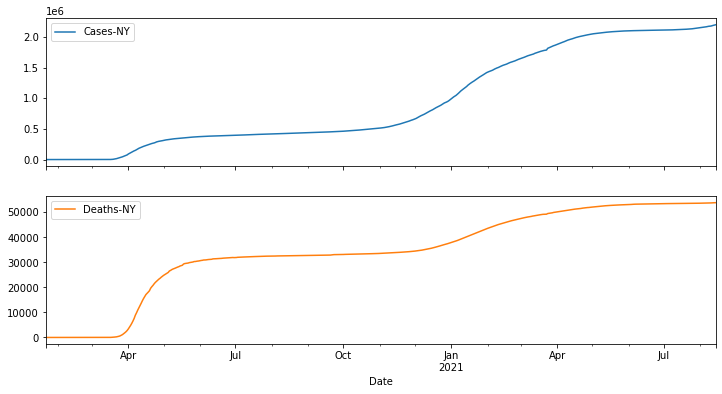

In [99]:
df_cumulative = STATES['NY'].copy()
df_cumulative.plot(subplots=True)

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

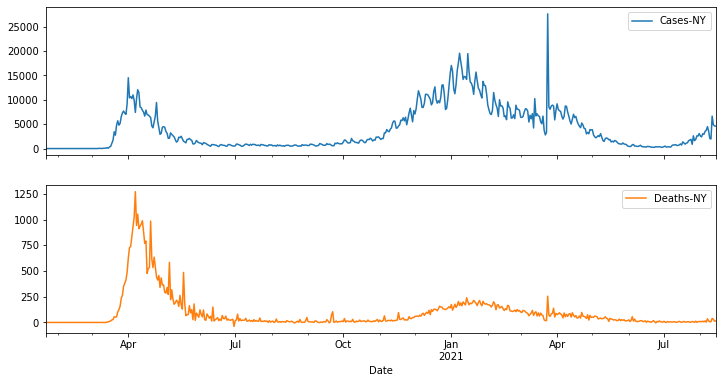

In [100]:
df_diff = STATES['NY'].copy().diff().fillna(0)
df_diff.plot(subplots=True)

### Saving CSVs

In [101]:
import os
# folder = "./data/"
folder = os.path.join(fpath_clean,'state_data/')
os.makedirs(folder,exist_ok=True)
os.listdir(folder)

[]

# OLD

### ❌"COVID-19 Reported Patient Impact and Hospital Capacity by State" [NOT TIME SERIES!!!]

- https://healthdata.gov/dataset/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/6xf2-c3ie

In [ ]:
# ## JSON way - From https://dev.socrata.com/foundry/healthdata.gov/6xf2-c3ie

# #!/usr/bin/env python

# # make sure to install these packages before running:
# # pip install pandas
# # pip install sodapy

# import pandas as pd
# from sodapy import Socrata

# # Unauthenticated client only works with public data sets. Note 'None'
# # in place of application token, and no username or password:
# client = Socrata("healthdata.gov", None)

# # Example authenticated client (needed for non-public datasets):
# # client = Socrata(healthdata.gov,
# #                  MyAppToken,
# #                  userame="user@example.com",
# #                  password="AFakePassword")

# # First 2000 results, returned as JSON from API / converted to Python list of
# # dictionaries by sodapy.
# results = client.get("6xf2-c3ie", limit=2000)

# # Convert to pandas DataFrame
# results_df = pd.DataFrame.from_records(results)
# results_df

In [ ]:
# ## CSV way
# url ="https://healthdata.gov/resource/6xf2-c3ie.csv"
# df0 = pd.read_csv(url,parse_dates=True)
# df0


In [ ]:
# df0.info()

In [ ]:
# df0.nunique()